<a href="https://colab.research.google.com/github/patero22/PyTorch_Course/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch workflow

Let's explore an PyTorch end-to-end workflow.

**what were covering** :
* data (prepare and load)
* build model
* fitting the model to data (training)
* making predictions and evaluating a model (inference)
* saving and loading a model
* putting it all together

In [1]:
import torch
from torch import nn #nn contains all of PyTorch's building blocks for graphs
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.3.0+cu121'

## 1. Data (preparing and loading)

Data can be almost anything ... in machine learning
* Excel
* Images
* Videos
* Audio
* Dna
* Text
* ...

Machine learing is a game of two parts:
1. Get data into a numerical representation
2. Build model to learn paaterns in that numerical representation

We 'll use a linear regression formula to make a straight line with known **parameters**

In [2]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Creat
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[0:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into training and test sets

In [3]:
len(X), len(y)

(50, 50)

In [4]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:],y[train_split:]

len(X_train), len(y_test)

(40, 10)

In [5]:
#X_train, y_train

Visualization

In [6]:
def plot_prediction(train_data=X_train,
                    train_labels=y_train,
                    test_data=X_test,
                    test_labels=y_test,
                    predictions=None):
  plt.figure(figsize=(10,7))
  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="training data")

  #Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="testing data")

  #Are there predictions?
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Sow the legend
  plt.legend(prop={"size": 14});


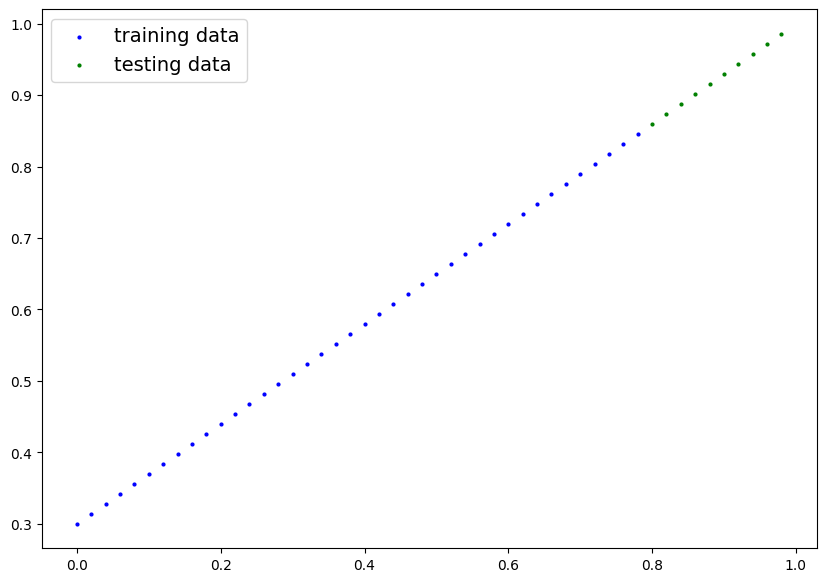

In [7]:
plot_prediction()

## 2. Build model

What our model does:
* Start with random balues (weights & bias)
* Look at training data and adjust the random values to better represent( or get closer to ) the idealvalues (ones we used to create the data)

How does it do so?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [8]:
# Create a linear regression model class

from torch import nn #nn is neaural network shortcut

class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch comes from nn.Module (base class for all neural network modules)
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True, #if parameter requires gradient
                                            dtype=torch.float) #default
                                )
    self.bias = nn.Parameter(torch.randn(1,
                                            requires_grad=True, #if parameter requires gradient
                                            dtype=torch.float) #default
                                )
  # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data
    return self.weights * x + self.bias #regression formula


### PyTorch model building essentials
*  torch.nn
* torch.nn.Parameter
* torch.nn.Module
* torch.optim - optimizers in PyTorch, will help with gradient descent
* def forward() - All nn.Model subclasses  require you to oberwrite forward()

### Checking the contents of our PyTorch model

So we can check out our model parameters or what's inside using .parameters()

In [9]:
# Create a random seed
torch.manual_seed(42)
# Create an instance of the model (subclass of nn.Module)

model_0 = LinearRegressionModel()

In [10]:
# Chec out th parameters
model_0.parameters()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [11]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [12]:
X_test

tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])

### Making preditions using torch.inference_mode()

when we pass data through our model it's going to run it through the forward() method.

In [13]:
# Make predictions with model
with torch.inference_mode(): #function don't use gradient descent so less data, more faster script
  y_preds = model_0(X_test)

# with torch.no_grad(): #kinda the same
#   y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [14]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

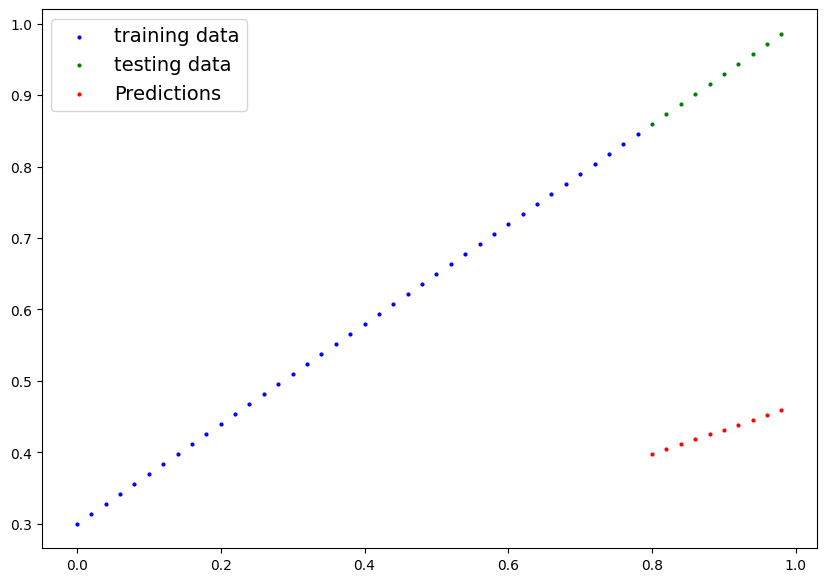

In [15]:
plot_prediction(predictions=y_preds)

## 3. Train model

One way to measure how poor or how wring your model predictions are is loss function
* Note: Loss function may also be called cost function or criterion in different areas. For our case, we're going to refer to it as a loss function

Things we need to train:

* **Loss function:** A lower is better

* **Oprimizer**: Takes into account the loss of a model and adjusts the model's parameters

And in PyTorch we need:
* A training loop
* A testing loop


In [16]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [17]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [18]:
# Setup a loss fucntion
loss_fn = nn.L1Loss()

# Setup an optimizer #Stochastic gradient descent
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # lr = learning rate = possibly the most importart hyperparameter you can set, (how much precison model will change by learning, how many decimal parts of parameter will change (in one iteration I guess))


In [19]:
loss_fn

L1Loss()

In [20]:
optimizer

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### Building a training (and testing) loop in PyTorch

A couple of things we need in a training loop:
0. Loop through the data
1. Forward pass (this involves data moving through our model's 'forward'() function) to make predictions on data - also called forward propagation
2. Calculate the loss (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backwords through the network to calculate the gradients of each of the parameters of our model with respect to the loss (**backpropagations**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss (**gradient descent**)

In [21]:
# An epoch is one loop through the data... #this is a hyperparameter becasue we've set it ourselves
epochs = 200

epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_0.train() #Train mode in PyTorch sets all parameters that require gradients to require gradients

  #1. Forward pass
  y_pred=model_0(X_train)

  #2. Calculate the loss
  loss = loss_fn(y_pred, y_train)
  #print(f"Loss:{loss}")

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Perform backpropagation on the loss with respect to the parameters of the midel
  loss.backward()

  #5. Step the optimizer (perform gradient descent)
  optimizer.step() # by default how the optimizer changes will acculumate through the lopp so... we have to zero them above in the step 3, because it willu se allways the same ones

  ### Testing
  model_0.eval() # turns off gradient tracking that is needed for evaluating/testing (dropout/batch norm layers)
  with torch.inference_mode(): # turns off gradient tracking & a couple things behind the scenes #with torch.no_grad()
    # 1. Do the forward pass
    test_pred = model_0(X_test)
    # 2. Calculate the loss
    test_loss = loss_fn(test_pred, y_test)
  # Printing what's happening
  if epoch % 10 ==0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 | Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 | Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | Loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch: 100 | Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 110 | Loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch: 120 | Loss: 0.01758546568453312 | Test loss: 0.04060482233762741
Epoch: 130 | Loss: 0.014155393466353416 | Test loss: 0.03233227878808975
Ep

In [22]:
import numpy as np

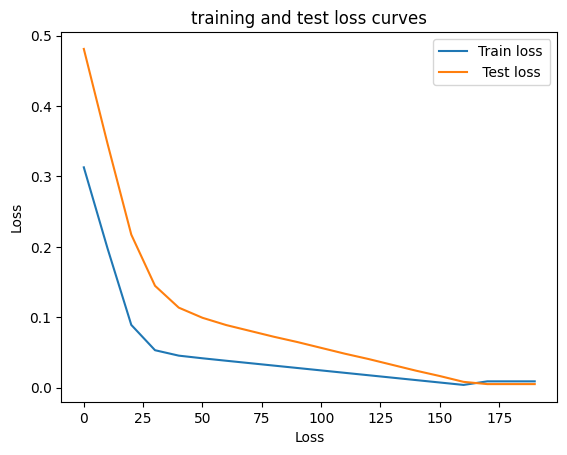

In [23]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")

plt.plot(epoch_count, test_loss_values, label=" Test loss ")
plt.title("training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Loss")
plt.legend();

In [24]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [25]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

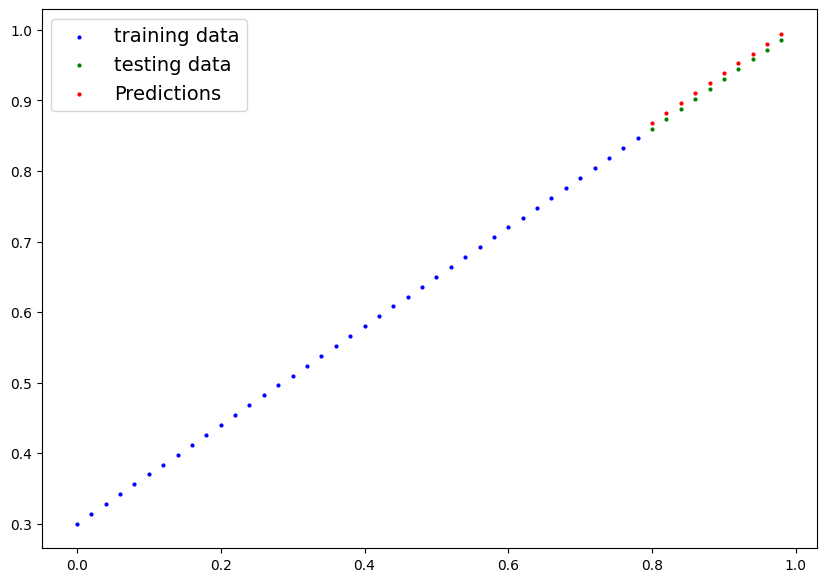

In [26]:
plot_prediction(predictions=y_preds_new)

## 5. Saving and loading a PyTorch model



    Note: As stated in Python's pickle documentation, the pickle module is not secure. That means you should only ever unpickle (load) data you trust. That goes for loading PyTorch models as well. Only ever use saved PyTorch models from sources you trust.


### Saving a PyTorch model's state_dict()

The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's state_dict().

Let's see how we can do that in a few steps:

    We'll create a directory for saving models to called models using Python's pathlib module.
    We'll create a file path to save the model to.
    We'll call torch.save(obj, f) where obj is the target model's state_dict() and f is the filename of where to save the model.

    Note: It's common convention for PyTorch saved models or objects to end with .pt or .pth, like saved_model_01.pth.


In [27]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)


Saving model to: models/01_pytorch_workflow_model_0.pth


In [28]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth



-rw-r--r-- 1 root root 1680 Jul 16 13:39 models/01_pytorch_workflow_model_0.pth


## Loading a PyTorch model
Since we saved our model's `state_dcit()` rather the entire model, we'll create a new instance of our model class and load `state_dict()` into that.

In [29]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [30]:
# To load in a saved state_dict we have to instantiate a new instance of our model class
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [31]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [32]:
# Make some predictions with our loaded model
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)
loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [33]:
# Compare loaded model preds with original model preds
y_preds_new == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6. Putting it all together


In [34]:
# import PyTorch and matplotlib
import torch
import matplotlib.pyplot as plt
from torch import nn

# Check PyTorch version
torch.__version__

'2.3.0+cu121'

Create device-agnostic code.
Theis means of we've got access to a PGU, our code wull it( for pottentiallyy faster computing)
If no GPU available, the code will deafuslt to using CPU

In [35]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [36]:
!nvidia-smi

Tue Jul 16 13:39:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 6.1 Data

In [37]:
# Create some data using the linear regression formula of y = weight * X + bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will pop out
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [38]:
# Split data
train_split= int(0.8 * len(X))
X_trin, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train)


40

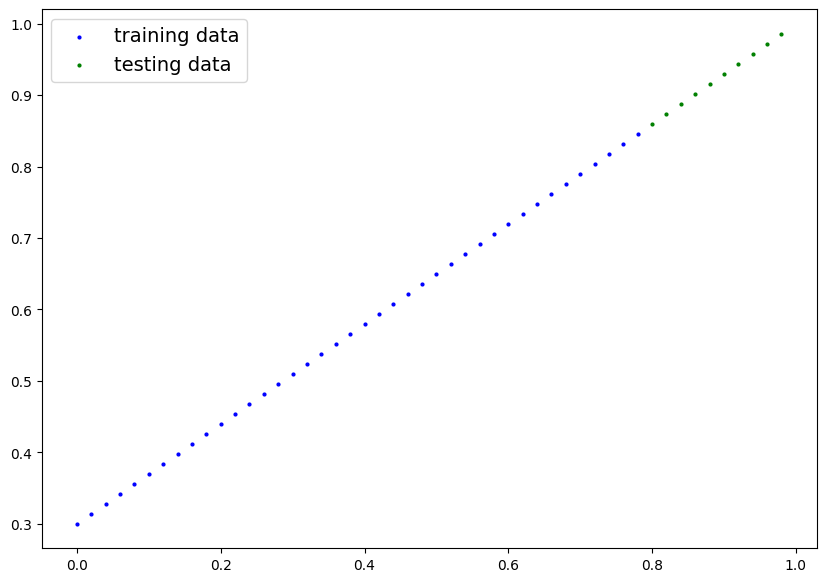

In [39]:
# Plot the data
# Note: if you don'y have the plot_predictions() function loaded, this will error
plot_prediction(X_train, y_train, X_test, y_test)

### 6.2 Building a PyTorch Linear model

In [51]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [52]:
# Check the model current device
next(model_1.parameters()).device

device(type='cpu')

In [53]:
# Set the nidek to use the target device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.3 Training

For training we need:
* Loss function
* Optimizer
* Training loop
* Testing loop

In [58]:
# Setup the loss function
loss_fn = nn.L1Loss() # same as MAE (Mean Absolute Error)

# Setup our optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.01) # Stochastic Gradient Descent



In [59]:
# Let's write a training loop
torch.manual_seed(42)

epochs = 200

# Put data on the target device (device agnostic code for data)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
  model_1.train()

  # 1. Forward pass
  y_pred = model_1(X_train)

  # 2. Calculate the loss
  loss = loss_fn(y_pred, y_train)

  # 3. Optimzier zero grad
  optimizer.zero_grad()

  # 4. Perform backpropagation
  loss.backward()

  # 5. Optimzier step
  optimizer.step()

  ### Testing

  model_1.eval()
  with torch.inference_mode():
    test_pred = model_1(X_test)

    test_loss = loss_fn(test_pred, y_test)

  # Print out what's happening
  if epoch % 10 ==0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 10 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 20 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 30 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 40 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 50 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 60 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 70 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 80 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 90 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 100 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 110 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.001264503574930

In [61]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### 6.4 Making and evaluating predictions

In [62]:
# Turn model into evaluatuin mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

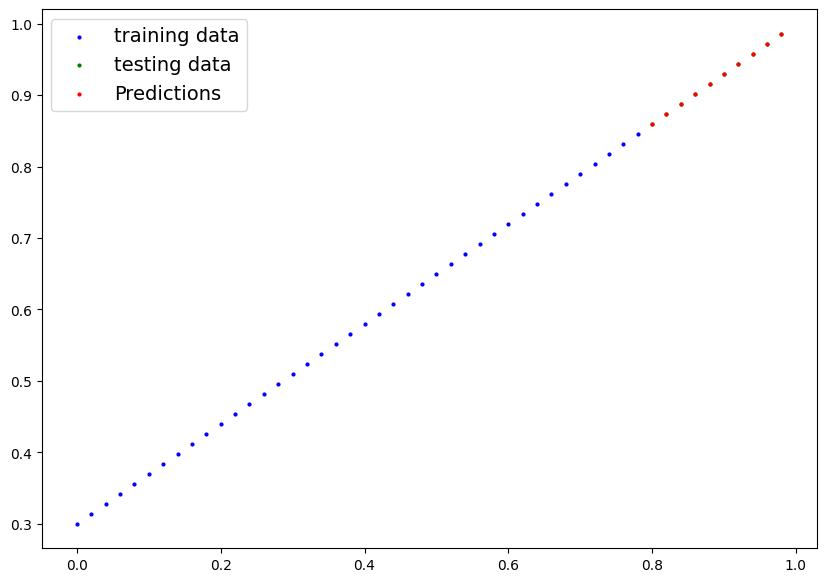

In [64]:
# Check out our model predictions visually
plot_prediction(predictions=y_preds.cpu())

### 6.5 Saving & loading a trained model

In [68]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create a model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


In [69]:
# Load a PyTorch model

# Create a new instance of linear regression model V2
loaded_model_1 = LinearRegressionModelV2()

# Load the saved model_1 state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put the loaded model to device
loaded_model_1.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [71]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [72]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [75]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')